# Reinforcement learning techniques for solving Frozen Lake

*by Mridula Bontha 30th November 2018* 

## Introduction

Frozen lake is a navigation game problem. The game's environment consists of a 4×4 grid which has four possible areas 
* Safe (S)
* Frozen (F)
* Hole (H)
* Goal (G). 

The aim of the game is to move the agent around the grid until it reaches the goal without falling into any of the holes. If the agent happens to fall into any of the hole, it has to start again from the beginning. This process continues until it learns from every mistake and reaches the goal ultimately. Below image depicts 4x4 Froze lake environment:

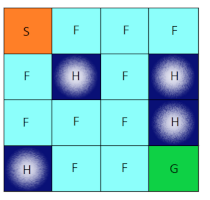

The agent has 4 possible moves in the given environment i.e **Left, Right, Down, Up** represented by 0,1,2,3 respectively. 

For a given state S and next possible state  S+1 and a given move *m*, the agent is rewarded 1 if that corresponding moves takes it to the goal otherwise if the agent dies by falling in the hole, it is rewarded 0.

By understanding various reinforcement learning techniques for Frozen Lake navigation problem, it would be helpful for us to implement the same for different navigation problems in real world scenarios like robot navigation or virtual car navigation in a given environment.

## Methods used
All the learning methods implemented use epsilon greedy stratergy. 

#### What is a Greedy startergy?

* Epsilon greedy algorithm determines whether to take a greedy move or a random move in accordance to a small value defined by epsilon. 

* For every episode of the game, if a random number generaed is less than epsilon value, a random move is choosen from the action space available for the given environment, otherwise a greedy move is taken.

* A greedy move corresponds to the maximum reward move from the current state.

I am using below three reinforcement techniques in my project:

1. Monte Carlo reinforcement learning
2. Q learning with Q table.
3. Q learning with neural networks.

Each of the learning technique has been explained in detail in below sections.

For implementing above techniques, I am using **Open AI Gym** Frozen Lake environment.It is an open-source library, which gives a convinient access to a set of definite set of environments along with possible states and actions for that environment.

OpenAI Gym enables episodic simulation of reinforcement learning. Agent's learning is expressed as a series of episodes. 
Agent's. For every episode, agent's initial stage is randomly determined from a distribution in an adaptive fashion from it's previous stage. This process continues until a final stage is reached. The purpose of the episodic reinforcement learning is to maximize the total reward earned and achieve this in minimum possible episodes.

## Implementation

For building much of my code, I have referred Arthur Juliani's blog on Simple Reinforcement Learning with Tensorflow. This blog provides a great implementation of Q-Learning with table and Q-Learning with Neural Networks.

## Import Statements

In [6]:
import gym_utils as utils
import gym
import random
from IPython.display import clear_output,display
from time import sleep
import numpy as np
from random import randint
import time
from keras.models import Sequential
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Helper functions

* **argmax_Q** - Returns the index of the (state,action) which has maximum reward.
* **greedy_policy** - Implements argmax function. Greedy policy returns a best possible action for a given state by examining the reward for each state action pair from current step to next step. Any transition with maximum reward is selected for further exploration.
* **create_state_action_dictionary** - Creates a placeholder/dictionary for holding (state,action) tuple for every possible move                                      from current state. It is initialized with 0 values. This dictionary is updated by various                                      policies defined in the below sections.
* **test_policy** - tests a given policy for 10000 random games and computes the franction of games won.
* **create random policy** - This creates an empty dictionary to store state action values

In [132]:
def argmax_Q(Q, s):            
    Q_list = list(map(lambda x: x[1], Q[s].items())) 
    indices = [i for i, x in enumerate(Q_list) if x == max(Q_list)]
    max_Q = random.choice(indices)
    return max_Q

def greedy_policy(Q):
    policy = {}
    for state in Q.keys():
        policy[state] = argmax_Q(Q, state)
    return policy

def field_list(env):
    l = []
    for row in list(map(lambda x: list([str(y)[-2] for y in x]), list(env.env.desc))):
        for field in row:
            l.append(field)
    return l   

def create_state_action_dictionary(env, policy):
    Q = {}
    fields = field_list(env)
    for key in policy.keys():
        if fields[key] in ['F', 'S']:
            Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
        else:
            Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
    return Q

def test_policy(policy, env,learning_policy):
    wins = 0
    r = 10000
    stepsToGoal =[]
    for i in range(r):
        episode = run_game(env, policy, learning_policy,display=False)
        stepsToGoal.append(len(episode))
        w = episode[-1][-1]
        if w == 1:
            wins += 1        
    return (wins*100 / r),min(stepsToGoal)

def create_random_policy(env):
    policy = {}
    for key in range(0, env.observation_space.n):
        current_end = 0
        p = {}
        for action in range(0, env.action_space.n):
            p[action] = 1 / env.action_space.n
        policy[key] = p
    return policy

### Run the game

**run_game** runs the game for a given policy and builds (action,reward) dictionary for a given state of the environment.

In [133]:
def run_game(env, policy, learning_policy,display=True,should_return=True):
    env.reset()
    episode = []
    finished = False
    count=0
    
    while not finished:
        s = env.env.s
            
        if display:
            clear_output(True)
            env.render()
            sleep(2)

        timestep = []
        timestep.append(s)
        if learning_policy=="q-learning-neural-networks":
            n = random.uniform(0, sum(policy[s].values()))
            top_range = 0
            for prob in policy[s].items():
                top_range += prob[1]
                if n < top_range:
                    action = prob[0]
                    break   

            state, reward, finished, info =  env.step(action)
            count+=1
            timestep.append(action)
            timestep.append(reward)
            episode.append(timestep)   

        elif learning_policy == 'q-learning' or learning_policy== "monte-carlo":
            action = policy[s]
            state, reward, finished, info =  env.step(action)
            count+=1
            timestep.append(action)
            timestep.append(reward)
            episode.append(timestep)
    if display:
        clear_output(True)
        env.render()
        sleep(0.5)
        print("Steps taken:",count)
    
    if should_return:
        return episode

## Policies

As a part of my project, I am doing a comparision on performance of three different policies on Frozen Lake game. I am considering only non-slippery version of game with 4x4 and 8x8 dimensions.

### 1. Q-Learning

In **Q-Learning Model** we build a A table of size States X Actions where States is a set of all possible states and Action is a set of all possible actions in given environment. For every state, Q table defines the likeliness of choosing an action from that state.

Initially Q table is loaded with zeroes. For every iteration, and for every move from current state, if the move gives a good reward for next state the corresponding Q value is increased and vice versa.

Values of Q learning table are updated as below :

$$ Q(S_t, A_t) \Leftarrow Q(S_t, A_t) + exploration rate[R_{t+1} + step size * \underset{\mathbf{\alpha}}{max} Q(S_{t+1}, a) - Q(S_t, A_t)]$$

**step_size** is the discount factor. It tells how much importance we give for future rewards. step_size varies from 0 to 1. If step_size is closer to zero, the agent will tend to consider only immediate rewards. If step_size is closer to one, the agent will consider future rewards with greater weight,thus willing to delay the reward.

**exploration_rate** is the learning rate, which defines how fast algorithm should learn. A 0 learning rate means that the Q-values are never updated, impying nothing is learned. A higher value of alpha such as 0.9 means that learning can occur quickly.



**Q-Learning Steps**

1. Initialize Q(s, a), for all s ∈ S, a ∈ A(s) where S is the set of all possible states and A is the set of all possible actions, with -1.Set Q(terminal_state, ·) = 0

2. Do for each repetition or episode, 
    * Initialize s with start_state, action = None and state = None
    * Do for each step of episode or repetition
        * choose a greedy move using epsilonGreedy policy
        * Take action a chosen above on state s
        * Update Q value using 
        $$ Q(S_t, A_t) \Leftarrow Q(S_t, A_t) + \alpha[R_{t+1} + \gamma * \underset{\mathbf{\alpha}}{max} Q(S_{t+1}, a) - Q(S_t, A_t)]$$
        * Set action and state with currentaction and currentstate respectively
        * Update currentaction and state by taking action selected above
        * Terminate if goal is reached

In [134]:
def Q_learning(env, episodes=100, step_size=0.01, exploration_rate=0.01):
    policy = utils.create_random_policy(env)
    Q = create_state_action_dictionary(env, policy)
    rewardList=[]
    for episode in range(episodes):
        totalReward=0
        env.reset()
        S = env.env.s
        finished = False
        while not finished:
            A = greedy_policy(Q)[S]
            S_prime, reward, finished, _ = env.step(A)
            Q[S][A] = Q[S][A] + step_size * (reward + exploration_rate * max(Q[S_prime].values()) - Q[S][A])
            S = S_prime
            totalReward += reward
        rewardList.append(totalReward)
    print("Percent of succesful episodes: " + str(sum(rewardList)*100/episodes) + "%")
    return greedy_policy(Q), Q,str(sum(rewardList)*100/episodes)

### 2. Monte-Carlo 

Monte Carlo control is a type of algorithm which first guesses values for states and then builds a greedy policy on them. With the obtained greedy policy, it them uses it to create another guess. Monte Carlo algorithm deals with following 4 parameters :

* **env** – This is the open AI gym env variable, in our case it would be a 4x4 or 8x8 frozen lake environment with 16 and 64 discrete possible states respectively.

* **episodes** – the number of episodes determines our guesse. For every episode, some amount of knowledge is being learned by the agent which helps it to play the game more efficiently in the subsequent episoded.

* **policy** – We can either use an exisiting policy to improvise it or can define a random policy. In our case we are generating a random policy for every play.
            
* **epsilon** – Epsilon is the exploration rate which determines a probabilty of choosing a random action instead of the greedy              one.

Algorithm follows:

* For all possible states and all possible actions for given environment, Initialize
   * policy $\Leftarrow$ A random policy
   * Q(state,action) $\Leftarrow$  with 0 initial values. This table is used for storing rewards.
   * n_state_action $\Leftarrow$ empty list
   
* For each iteration in num_episodes, do
   * While game is not finished,
      * for a random value r,
          * if r < epsilon: take a random action
          * else : take a greedy action
          
    * generate episode using policy
    * append state action of above episode into final result list
    * sum up the rewards for each state,action obtained from above episode
    * Take the mean of all episodes for calculating Q values

* Compute percentage of episodes won by summing up the rewards in rewarList and average them with number of episodes.



In [135]:
def monte_carlo(env, episodes=100, policy=None, epsilon=0.01):
    rewardList = []
    finished = False
    policy = utils.create_random_policy(env)
    Q = create_state_action_dictionary(env, policy)
    n_s_a = np.zeros([env.observation_space.n, env.action_space.n])
    for i in range(episodes):
        state = env.reset()
        totalReward = 0
        finished = False
        results_list = []
        result_sum = 0.0
        while not finished:
            action = greedy_policy(Q)[state]
            new_state, reward, finished, _ = env.step(action)
            results_list.append((state, action))
            state = new_state
            totalReward += reward
        rewardList.append(totalReward)

        #monte carlo update
        for (state, action) in results_list:
            n_s_a[state, action] += 1.0
            alpha = 1.0 / n_s_a[state, action]
            Q[state][action] += alpha * (totalReward - Q[state][action])

    print("Percent of succesful episodes: " + str(sum(rewardList)*100/episodes) + "%")  
    return greedy_policy(Q),Q,str(sum(rewardList)*100/episodes)


## 3. Q-Learning Neural Networks

In case of reinforcement learning with neural networks, we use a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values for eac of the action. In this case, weights act as a means for olding old Q values.

The difference between Q Learning and Deep Q learning ( DQL ) can be understood from the below image :

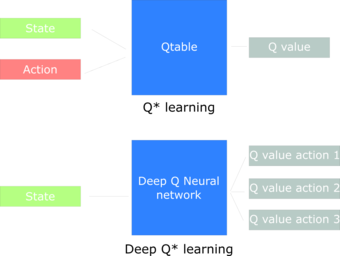

Unlike Q table learning we do an update on Q by using back propogation and loss function. The loss function we use is sum of sqaured loss. Here, loss is the difference between the current predicted Q-values, and its corresponding actual value computed using the gradients passed through the network.

$$ Loss = \sum(Q_{target} - Q_{current})^2 $$

* We have **X** which is a place holder for input values of size 1 x lake_size

* **W** is used for holding weights, I am using random uniform initialization of weights.

* I am using GradientDescent optimizer for minimizing the loss function. The performance of gradient descent depends hugely on learning rate of the model. Larger learning rate causes gradient descent to take big steps while trying to move towards global minima, and smaller learning rate makes the model to take small steps trying to converge. This feature of gradient descent leaves us enough space to experiment with different learning rates.
 
* After evaluation the current state, we are determining the next action according to the value of epsilon (e)

* Using the action computed in above step, we will compute next state ( Q2 ) state,action dictionary.

* Reward for every move is obtained by applying loss fucntion for the current state and next state obtained in the abovr step.

* Using backpropogation and he reward obtained in above step, we will update current Q value.


In [136]:
def Q_learning_neural_network(env,lake_size=16,episodes=2000,e=0.1,lr=0.99):
    accurracies = []
    rewards = []
    # Training tuning
    e_decay = 0.999
    y = .95
    rList=[]
    
     # Training loop
    episode_count = 0
    total_steps = 0
    nb_actions = env.action_space.n
    


    x = tf.placeholder(shape=[1,lake_size],dtype=tf.float32)
    W = tf.Variable(tf.random_uniform([lake_size,4],0,0.01))
    Qout = tf.matmul(x,W)

    nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    trainer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    update_model = trainer.minimize(loss)

    init = tf.global_variables_initializer()
    policy = utils.create_random_policy(env)
    with tf.Session() as sess:
        sess.run(init)

        while episode_count < episodes:
            state = env.reset()
            finished = False
            reward_tot = 0
            episode_step = 0
            j=0
            while j < 100:
                j+=1
                episode_step += 1

                # Eval current state
                Q1 = sess.run(Qout, feed_dict={x: np.identity(lake_size)[state:state+1]})[0]

                if random.random() < e:
                    #random move
                    action = random.randint(0, nb_actions-1)
                else:
                    #greedy move
                    action = np.argmax(Q1)

                # Play best move with chance of random
                next_state, reward, finished, _ = env.step(action)

                # Eval next state
                Q2 = sess.run(Qout, feed_dict={x: np.identity(lake_size)[next_state:next_state+1]})[0]

                # Update first state evaluation
                Q1[action] += lr * (reward + y*np.max(Q2) - Q1[action])
                policy[state][action] = Q1[action]
                sess.run(update_model,feed_dict={x: np.identity(lake_size)[state:state+1], nextQ:[Q1]})

                reward_tot += reward
                total_steps += 1
                state = next_state

                if finished:
                    break
            rList.append(reward_tot)
            e *= e_decay

            episode_count += 1
        env.close()
    print("Percent of succesful episodes: " + str(sum(rList)*100/episodes) + "%")   
    return policy,total_steps,str(sum(rList)*100/episodes)


## 4 x 4 Frozen Lake

### Monte Carlo epsilon greedy

In [138]:
env = utils.create_environment(slippery=False, big=False)
policy,Q,successful_episodes_mc4 = monte_carlo(env, episodes=10000,epsilon=0.8)
start_mc4 =time.time()
win_percentage_mc4,min_steps_mc4 = test_policy(policy,env,learning_policy='monte-carlo')
end_mc4 = time.time()
print("Win percentage:",str(win_percentage_mc4)+"%")
print("Minimum steps taken in 10000 random plays:",min_steps_mc4)
print("Time taken:",(end_mc4-start_mc4))

Percent of succesful episodes: 99.84%
Win percentage: 100.0%
Minimum steps taken in 10000 random plays: 6
Time taken: 0.573474645614624


In [49]:
run_game(env=env, learning_policy='monte-carlo',policy=policy, display=True,should_return=False)

  (Right)
SFFF
FHFH
FFFH
HFFG
Steps taken: 6


### Q Learning with table

In [50]:
env = utils.create_environment(slippery=False, big=False)
policy, Q,successful_episodes_q4 = Q_learning(env, episodes=10000, step_size=1, exploration_rate=0.88)
start_q4 =time.time()
win_percentage_q4,min_steps_q4 = test_policy(policy, env,learning_policy='q-learning')
end_q4 = time.time()
print("Win percentage:",str(win_percentage_q4)+"%")
print("Minimum steps taken in 10000 random plays:",min_steps_q4)
print("Time taken:",(end_q4-start_q4))

Percent of succesful episodes: 98.58%
Win percentage: 100.0%
Minimum steps taken in 10000 random plays: 6
Time taken: 0.5235996246337891


In [51]:
run_game(env=env, learning_policy='q-learning',policy=policy, display=True,should_return=False)

  (Right)
SFFF
FHFH
FFFH
HFFG
Steps taken: 6


### Q Learning with neural networks

In [78]:
env = utils.create_environment(slippery=False, big=False)
policy,steps_taken,successful_episodes_qnn4 =  Q_learning_neural_network(env,lake_size=16,episodes=10000,e=1.0,lr=0.8)
start_qnn4 =time.time()
win_percentage_qnn4,min_steps_qnn4 = test_policy(policy,env,learning_policy='q-learning-neural-networks')
end_qnn4 = time.time()
print("Win percentage:",str(win_percentage_qnn4)+"%")
print("Minimum steps taken in 10000 random plays:",min_steps_qnn4)
print("Time taken:",(end_qnn4-start_qnn4))

Percent of succesful episodes: 87.72%
Win percentage: 85.4%
Minimum steps taken in 10000 random plays: 2
Time taken: 8.264949798583984


In [79]:
run_game(env=env, learning_policy='q-learning-neural-networks',policy=policy, display=True,should_return=False)

  (Down)
SFFF
FHFH
FFFH
HFFG
Steps taken: 17


## 8 x 8 Frozen Lake

### Monte Carlo

In [80]:
env = utils.create_environment(slippery=False, big=True)
policy, Q,successful_episodes_mc8 = monte_carlo(env, episodes=100000,epsilon=1)
start_mc8 =time.time()
win_percentage_mc8,min_steps_mc8 = test_policy(policy,env,learning_policy='monte-carlo')
end_mc8 = time.time()
print("Win percentage:",str(win_percentage_mc8)+"%")
print("Minimum steps taken in 10000 random plays:",min_steps_mc8)
print("Time taken:",(end_mc8-start_mc8))

Percent of succesful episodes: 99.688%
Win percentage: 100.0%
Minimum steps taken in 10000 random plays: 16
Time taken: 1.2846031188964844


In [81]:
run_game(env=env, learning_policy='monte-carlo',policy=policy, display=True,should_return=False)

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Steps taken: 16


### Q Learning with table

In [83]:
env = utils.create_environment(slippery=False, big=True)
policy, Q,successful_episodes_q8 = Q_learning(env, episodes=100000, step_size=1, exploration_rate=0.88)
start_q8 =time.time()
win_percentage_q8,min_steps_q8 = test_policy(policy, env,learning_policy='q-learning')
end_q8 = time.time()
print("Win percentage:",str(win_percentage_q8)+"%")
print("Minimum steps taken in 10000 random plays:",min_steps_q8)
print("Time taken:",(end_q8-start_q8))

Percent of succesful episodes: 98.295%
Win percentage: 100.0%
Minimum steps taken in 10000 random plays: 14
Time taken: 1.1484594345092773


In [84]:
run_game(env=env, learning_policy='q-learning',policy=policy, display=True,should_return=False)

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Steps taken: 14


### Q Learning with neural networks

In [129]:
env = utils.create_environment(slippery=False, big=True)
policy,steps_taken,successful_episodes_qnn8 =  Q_learning_neural_network(env,lake_size=64,episodes=1000,e=1,lr=0.5)
start_qnn8 =time.time()
win_percentage_qnn8,min_steps_qnn8 = test_policy(policy,env,learning_policy='q-learning-neural-networks')
end_qnn8 = time.time()
print("Win percentage:",str(win_percentage_qnn8)+"%")
print("Minimum steps taken in 10000 random plays:",min_steps_qnn8)
print("Time taken:",(end_qnn8-start_qnn8))

Percent of succesful episodes: 17.1%
Win percentage: 26.01%
Minimum steps taken in 10000 random plays: 5
Time taken: 21.34631848335266


In [130]:
run_game(env=env, learning_policy='q-learning-neural-networks',policy=policy, display=True,should_return=False)

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Steps taken: 25


### Comparision table for 4x4 and 8x8 frozen lake for different learning techniques

In [139]:
column_names = [[ '4 x 4','4 x 4', '4 x 4', '4 x 4'], ['% successful episodes','Win percentage','Min steps','Time taken(s)']]
tuples = list(zip(*column_names))
index = pd.MultiIndex.from_tuples(tuples)
df_4x4 = pd.DataFrame(
np.array([successful_episodes_mc4,win_percentage_mc4,min_steps_mc4,(end_mc4-start_mc4),
          successful_episodes_q4,win_percentage_q4,min_steps_q4,(end_q4-start_q4),
          successful_episodes_qnn4,win_percentage_qnn4,min_steps_qnn4,(end_qnn4-start_qnn4)]).reshape(3,4),
index=['Monte Carlo','Q Learning','Q learning NN'], columns=index)


column_names = [['8 x 8', '8 x 8', '8 x 8', '8 x 8'], ['% successful episodes','Win percentage','Min steps','Time taken(s)']]
tuples = list(zip(*column_names))
index = pd.MultiIndex.from_tuples(tuples)
df_8x8 = pd.DataFrame(
np.array([successful_episodes_mc8,win_percentage_mc8,min_steps_mc8,(end_mc8-start_mc8),
          successful_episodes_q8,win_percentage_q8,min_steps_q8,(end_q8-start_q8),
          successful_episodes_qnn8,win_percentage_qnn8,min_steps_qnn8,(end_qnn8-start_qnn8)]).reshape(3,4),
index=['Monte Carlo','Q Learning','Q learning NN'], columns=index)
df_4x4.join(df_8x8)

4 x 4                           \
              % successful episodes Win percentage Min steps   
Monte Carlo                   99.84          100.0         6   
Q Learning                    98.58          100.0         6   
Q learning NN                 87.72           85.4         2   

                                                  8 x 8                 \
                    Time taken(s) % successful episodes Win percentage   
Monte Carlo     0.573474645614624                99.688          100.0   
Q Learning     0.5235996246337891                98.295          100.0   
Q learning NN   8.264949798583984                  17.1          26.01   

                                             
              Min steps       Time taken(s)  
Monte Carlo          16  1.2846031188964844  
Q Learning           14  1.1484594345092773  
Q learning NN         5   21.34631848335266

## Results

Above results were obtained by executing each learning policy 10000 random plays. The percentage of successful episode gives the success rate for given number of episodes. Whereas win percentage gives the number of games won for 10000 random plays. All the policies are based on greedy selection of action.

* From the above comparision table, we see that Monte Carlo performs the best followed for 4 x 4 and 8 x 8 version of Frozen Lake environment.

* In terms of time taken Q learning takes the minimum amount of time and gives accuracy near to the accuracy of monte carlo.

* In both versions of Frozen Lake environment, Q learning with Neural network takes minimum number of steps i.e it converges easily that other to algorithms. But Neura network takes nearly 15 times more time than Q learning and monte carlo policies.

* While the neural network learns to solve the FrozenLake problem, but it fails to learn as fast as Q learning with table and monte carlo. 

* The advantage of using neural networks permit for better flexibility but this happens at the cost of stability as compared to Q-Learning.

* Q-Learning with neural networks eventually becomes better when trained for large number of episodes.

## Conclusion

In Reinforcement learning, there is no set of predefined lables as a result the agent has to explore the environment on it's own and in order to learn from mistakes and take right moves eventually. This implies that such kind of learning is always prone to get glued at a plateau or local minima while trying to minimize the loss at each step. 

Reinforcement learning needs alot of experimenting and tuning in order to achive right set of parameters which would lead to faster and better learning of actions by the agent. 

Although reinforcement learning with neural networks comparitively need more time than regular on-policy learning techniques, but it eventually learns in much better way over a period of time. Also, neural network gives a lot of flexibilty with different optimzation techniques and loss functions. In other words, there is more scope of experimenting with neural networks that other policies.

Challenges that I faced includes fine tuning neural networks to achieve better performance and many times neural networks does not converge to goal state leading to a greater execution time and ultimately failing to reach goal state. I was able to achieve a fairly better performace for 4 x 4 lake environment but 8 x 8 could not perform well even after trying various parameter combinations. For example I experimented with higher and lower values for learning rates and epsilon but still, 8 x 8 did not perform well with neural network framework.

In [7]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('Frozen-Lake.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Frozen-Lake.ipynb is 2228


## References

https://github.com/openai/gym

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

https://www.analyticsindiamag.com/openai-gym-frozen-lake-beginners-guide-reinforcement-learning/

https://gist.github.com/yunsangq/b3e4c4b51c6c8b0dbae621b6b92c5cb5

https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8